# Success Prediction and Recommendation Systems for Google Apps Based on Rating and Sentiment Discrepancies


 Importing the common libraries at the start

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None

### 1. Data Understanding

In [ ]:
df = pd.read_csv('googleplaystore.csv')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [ ]:
# replace the space in the column names with an underscore.
df.columns = df.columns.str.replace(" ","_")

In [ ]:
# number of rows and columns in the dataset
df.shape

(10841, 13)

In [ ]:
# Here we can see that only Rating column is only in float.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content_Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last_Updated    10841 non-null  object 
 11  Current_Ver     10833 non-null  object 
 12  Android_Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


### 2. Data Preprocessing

Converting numerical columns into int and float

In [ ]:
# Checking For reviews

df[~df.Reviews.str.isnumeric()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated,Current_Ver,Android_Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


Reviews is non numeric and Rating is outlier, need to be to dropped

In [ ]:
# Dropping and converting to int

df = df.drop(df.index[10472])
df["Reviews"] = df["Reviews"].astype(int)

In [ ]:
# Checking For Size

print(len(df["Size"].unique()))
All_Sizes = df["Size"].unique()
print(All_Sizes[:100])  # Print the first 100 unique sizes

461
['19M' '14M' '8.7M' '25M' '2.8M' '5.6M' '29M' '33M' '3.1M' '28M' '12M'
 '20M' '21M' '37M' '2.7M' '5.5M' '17M' '39M' '31M' '4.2M' '7.0M' '23M'
 '6.0M' '6.1M' '4.6M' '9.2M' '5.2M' '11M' '24M' 'Varies with device'
 '9.4M' '15M' '10M' '1.2M' '26M' '8.0M' '7.9M' '56M' '57M' '35M' '54M'
 '201k' '3.6M' '5.7M' '8.6M' '2.4M' '27M' '2.5M' '16M' '3.4M' '8.9M'
 '3.9M' '2.9M' '38M' '32M' '5.4M' '18M' '1.1M' '2.2M' '4.5M' '9.8M' '52M'
 '9.0M' '6.7M' '30M' '2.6M' '7.1M' '3.7M' '22M' '7.4M' '6.4M' '3.2M'
 '8.2M' '9.9M' '4.9M' '9.5M' '5.0M' '5.9M' '13M' '73M' '6.8M' '3.5M'
 '4.0M' '2.3M' '7.2M' '2.1M' '42M' '7.3M' '9.1M' '55M' '23k' '6.5M' '1.5M'
 '7.5M' '51M' '41M' '48M' '8.5M' '46M' '8.3M']


Size has metric prefixes(kilo and Mega). Replacing k and M with their values to convert values to numeric (floating type)

In [ ]:
df['Size'] = df['Size'].str.replace('M', '000', regex=False)
df['Size'] = df['Size'].str.replace('k', '', regex=False)
df['Size'] = df['Size'].replace("Varies with device", np.nan)
df['Size'] = df['Size'].str.replace(',', '').str.replace('+', '')
df['Size'] = df['Size'].astype(float)

There is a problem! There are some applications size in megabyte and some in kilobyte.

In [ ]:
# Convert values below 10 MB (assumed to be KB) to MB
df['Size'] = df['Size'].apply(lambda x: x * 1000 if x < 10 else x)

# Convert all to megabytes
df['Size'] = df['Size'] / 1000

In [ ]:
# Check for Installs
df['Installs'].unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '50+', '100+', '500+',
       '10+', '1+', '5+', '0+', '0'], dtype=object)

Installs must be of integer type

In [ ]:
# Check for Price
df['Price'].unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', '$1.20', '$1.04'], dtype=object)

Price must be of floating type.

In [ ]:
#  Remove Characters and words from Price and Installs

items_to_remove = [',', '+', '$', 'Free', 'Everyone']
cols_to_clean = ['Installs', 'Price']

for col in cols_to_clean:
    df[col] = df[col].astype(str)  # Convert to string first if not string
    for item in items_to_remove:
      if item == 'Free' or 'Everyone':
        df[col] = df[col].str.replace(item, '0', regex=False)  # Replace 'Free' with 0
      else:
        df[col] = df[col].str.replace(item, '', regex=False)  # Remove special characters


df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce').fillna(0).astype(int)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce').fillna(0).astype(float)


Convert the date to datetime and extract Year, Month

In [ ]:

df['Last_Updated'] = pd.to_datetime(df['Last_Updated'], errors='coerce')

In [ ]:




df['Updated_Month']=df['Last_Updated'].dt.month
df['Updated_Year']=df['Last_Updated'].dt.year

### 3. Data cleaning

Handling Missing Data

In [ ]:
# missing data in columns
df.isnull().sum()

,0
App,0
Category,0
Rating,1474
Reviews,0
Size,1695
Installs,0
Type,1
Price,0
Content_Rating,0
Genres,0


In [ ]:
# use the median value for missing data in the rating and Size column.
df["Rating"].fillna(df["Rating"].median(), inplace=True)
df["Size"].fillna(df["Size"].median(), inplace=True)
# median is more robust for the outlier values.

In [ ]:
# remove the other missing data as it is very little.
df.dropna(inplace=True)

Delete Dublicated Data

In [ ]:
duplicate = df.duplicated()
print(duplicate.sum())

483


In [ ]:
df.drop_duplicates(inplace=True)

Dropping useless Variables

In [ ]:
df = df.drop(['Current_Ver', 'Android_Ver'], axis=1)

Final df Shape

In [ ]:
df.shape

(10346, 13)

### 4. EDA - Understanding and Exploring Trends



**App Category**

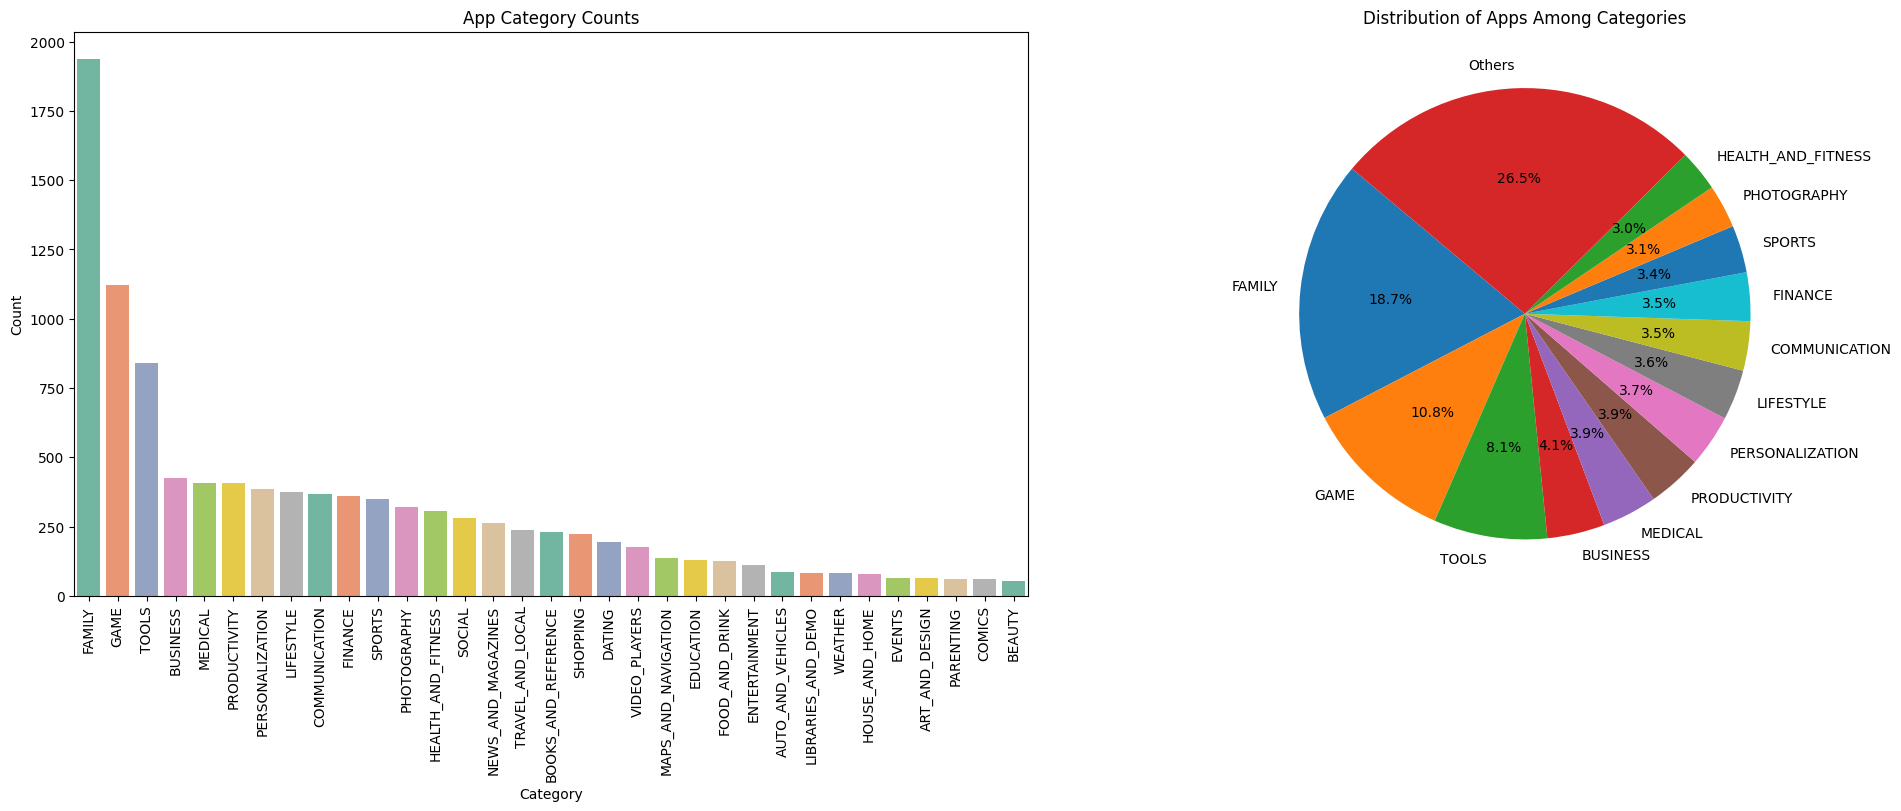

In [ ]:

# First row: Countplot and Pie Chart
fig, axes = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)

# Code 1: Countplot
sns.countplot(
    x='Category',
    data=df,
    order=df['Category'].value_counts().index,
    palette='Set2',
    ax=axes[0]
)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_title('App Category Counts')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')

# Code 2: Pie Chart with "Others"
category_counts = df['Category'].value_counts()
threshold = 0.029 * category_counts.sum()
filtered_counts = category_counts[category_counts >= threshold]
others_count = category_counts[category_counts < threshold].sum()
filtered_counts['Others'] = others_count

axes[1].pie(
    filtered_counts,
    labels=filtered_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 10}
)
axes[1].set_title('Distribution of Apps Among Categories')

# Show the combined plots
plt.show()


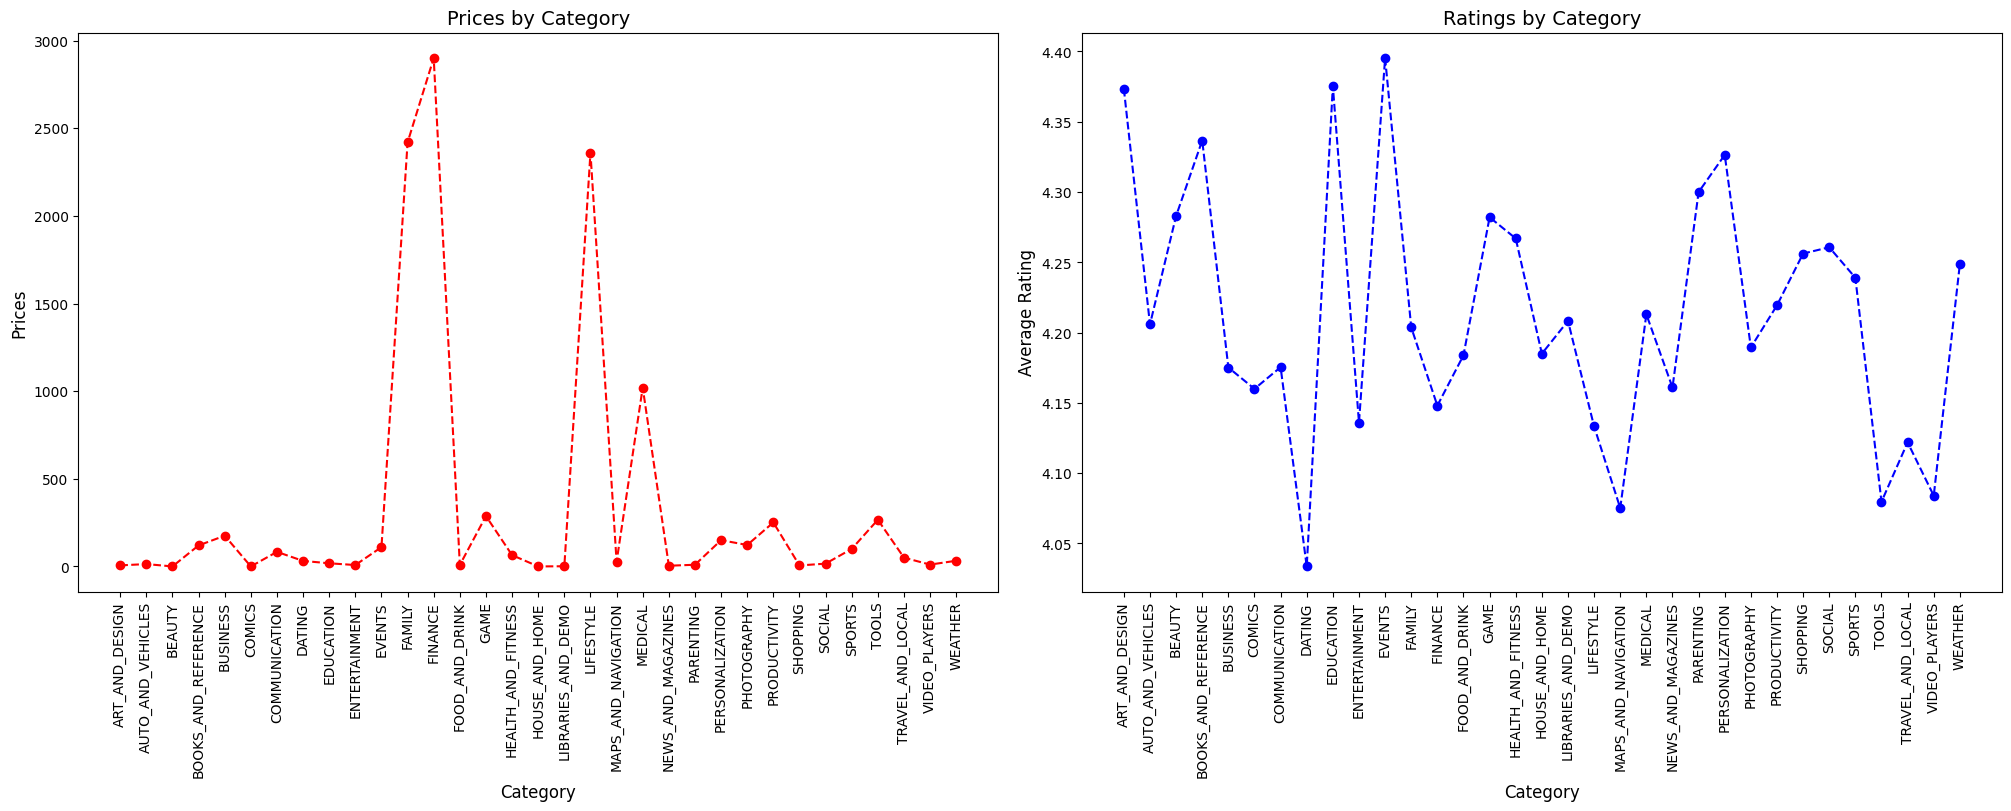

In [ ]:


# Group by 'Category' for Prices
category_prices = df.groupby('Category')['Price'].sum()

# Group by 'Category' for Ratings
category_ratings = df.groupby('Category')['Rating'].mean()

# Create a single figure with two line charts side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)

# Plot 1: Prices by Category
axes[0].plot(category_prices.index, category_prices.values, linestyle='--', color='r', marker='o')
axes[0].set_title('Prices by Category', fontsize=14)
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Prices', fontsize=12)
axes[0].tick_params(axis='x', rotation=90)

# Plot 2: Ratings by Category
axes[1].plot(category_ratings.index, category_ratings.values, linestyle='--', color='b', marker='o')
axes[1].set_title('Ratings by Category', fontsize=14)
axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('Average Rating', fontsize=12)
axes[1].tick_params(axis='x', rotation=90)

# Show the combined plots
plt.show()


**Distribution of apps ratings**

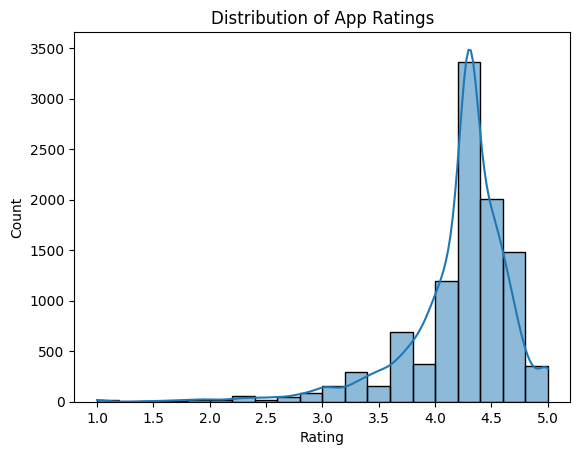

In [ ]:
sns.histplot(df['Rating'], bins=20, kde=True)
plt.title('Distribution of App Ratings')
plt.show()


**Free Vs Paid apps**

<Axes: ylabel='count'>

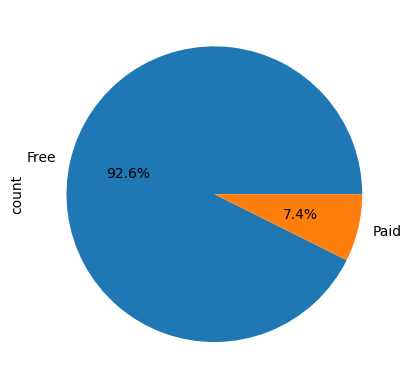

In [ ]:
df["Type"].value_counts().plot.pie(autopct = "%1.1f%%")

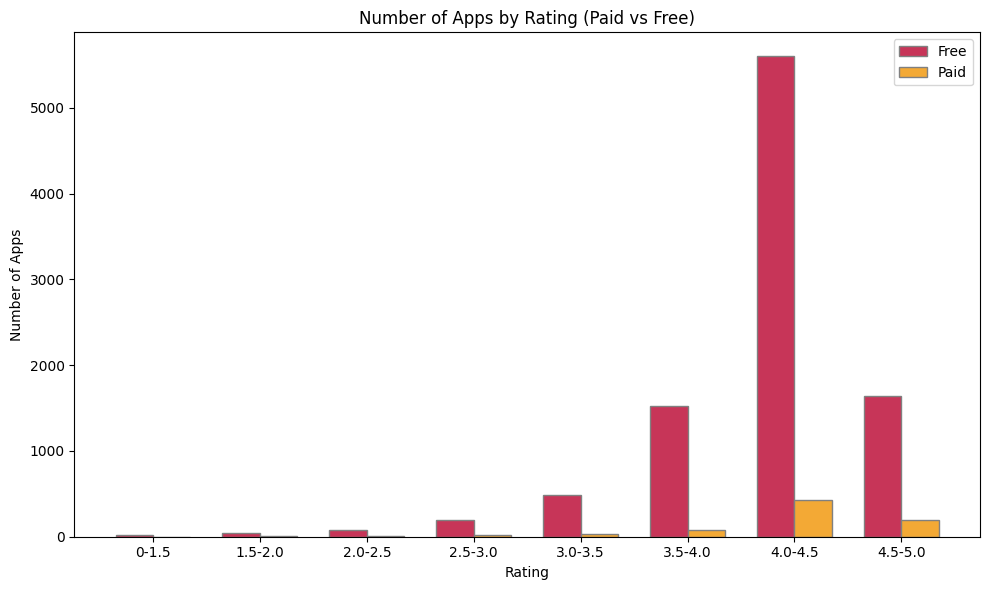

In [ ]:

df = df.dropna(subset=['Rating'])

# Set the bin edges for the ratings (1 to 5, with increments of 0.5)
bins = np.arange(1, 5.5, 0.5)

# Create a new column 'Rating_Bins' to categorize ratings into bins
df['Rating_Bins'] = pd.cut(df['Rating'], bins=bins, include_lowest=True)

# Group the data by 'Rating_Bins' and 'Type' and count the number of apps
rating_counts = df.groupby(['Rating_Bins', 'Type']).size().unstack(fill_value=0)

# Plot the bar chart
bar_width = 0.35  # Width of the bars
ratings = rating_counts.index  # X-axis labels (rating bins)
free_counts = rating_counts['Free']  # Y-values for Free apps
paid_counts = rating_counts['Paid']  # Y-values for Paid apps

# Set the position of bars on X-axis
r1 = np.arange(len(ratings))  # Position for Free bars
r2 = [x + bar_width for x in r1]  # Position for Paid bars

# Plot bars
plt.figure(figsize=(10, 6))
plt.bar(r1, free_counts, color='#c73558', width=bar_width, edgecolor='grey', label='Free')
plt.bar(r2, paid_counts, color='#f3a935', width=bar_width, edgecolor='grey', label='Paid')

# Manually setting the x-tick labels
xtick_labels = ['0-1.5', '1.5-2.0', '2.0-2.5', '2.5-3.0', '3.0-3.5', '3.5-4.0', '4.0-4.5', '4.5-5.0']
plt.xticks([r + bar_width / 2 for r in range(len(ratings))], xtick_labels)

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Number of Apps')
plt.title('Number of Apps by Rating (Paid vs Free)')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


**Update date vs Type**

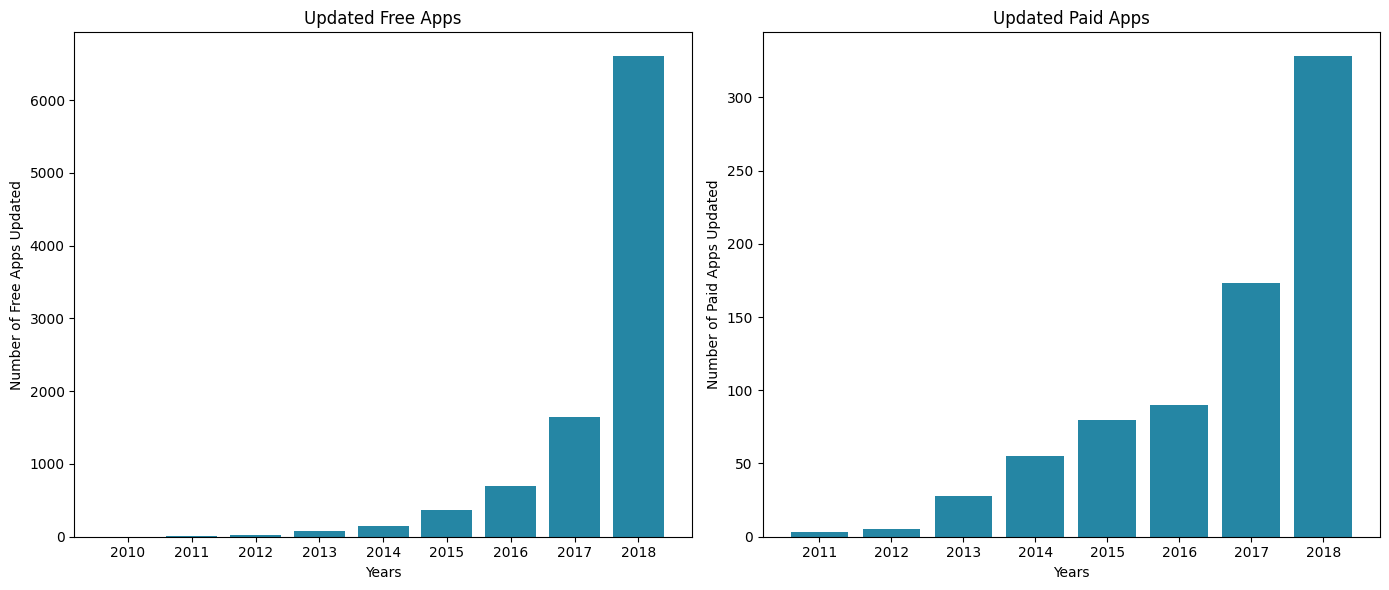

In [ ]:

app_types = ['Free', 'Paid']
app_data = {app_type: df[df['Type'] == app_type].groupby('Updated_Year').size() for app_type in app_types}

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Loop through app types and generate bar plots
for i, app_type in enumerate(app_types):
    axes[i].bar(app_data[app_type].index, app_data[app_type].values, color='#2586a4')
    axes[i].set_title(f'Updated {app_type} Apps')
    axes[i].set_xlabel('Years')
    axes[i].set_xticks(app_data[app_type].index)  # Set x-ticks to match the years present
    axes[i].set_xticklabels(app_data[app_type].index.astype(str))  # Convert years to string for labels

# Add y-labels with different scales
axes[0].set_ylabel('Number of Free Apps Updated')
axes[1].set_ylabel('Number of Paid Apps Updated')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


**Content Ratings**

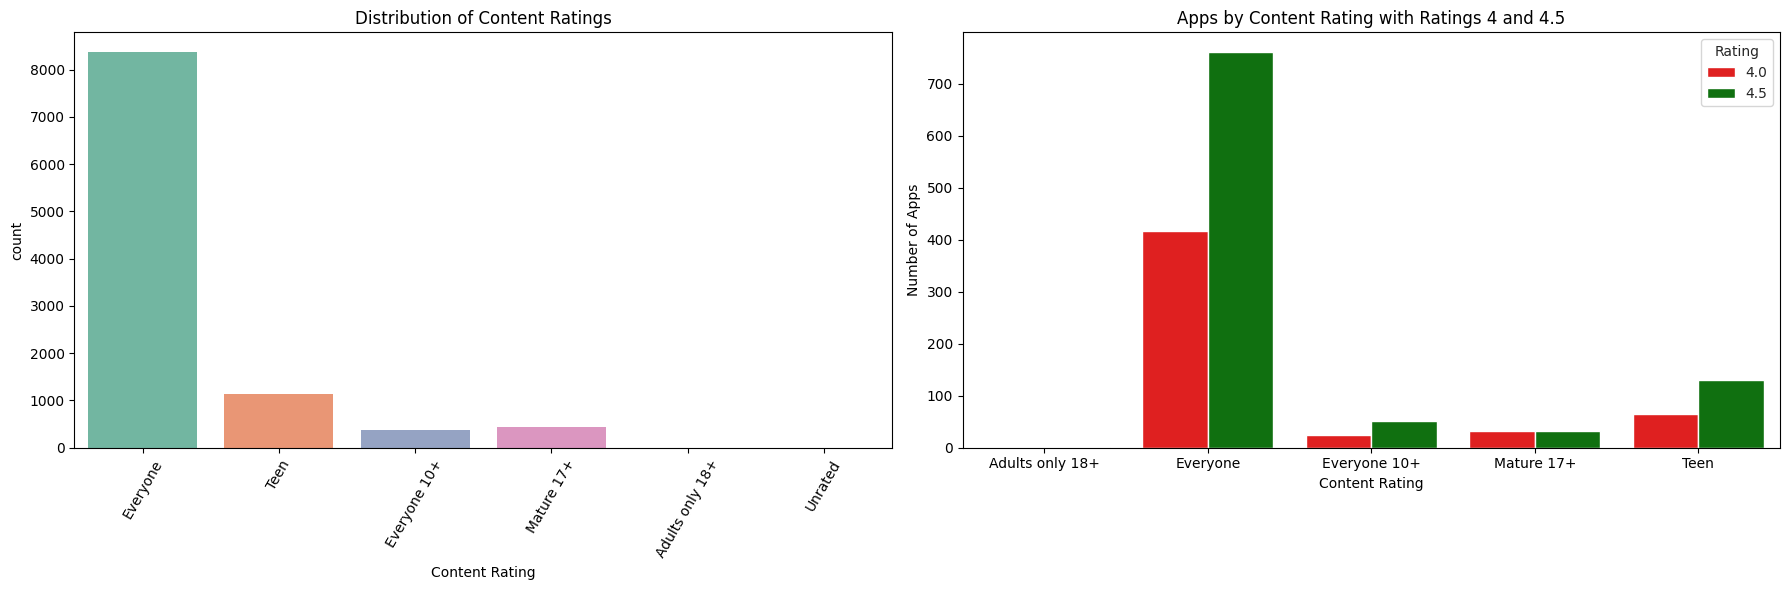

In [ ]:
# Create a figure with 1 row and 2 columns for subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Code 1: Distribution of Content Ratings
sns.countplot(x='Content_Rating', data=df, palette='Set2', ax=axes[0])
axes[0].set_xlabel('Content Rating')
axes[0].set_title('Distribution of Content Ratings')
axes[0].tick_params(axis='x', rotation=60)

# Code 2: Apps by Content Rating with Ratings 4 and 4.5
df_filtered = df[df['Rating'].isin([4, 4.5])]

# Group by 'Content Rating' and 'Rating' to count occurrences
grouped_data = df_filtered.groupby(['Content_Rating', 'Rating']).size().reset_index(name='Count')

# Set plot background to light
sns.set_style("whitegrid")

# Plot a grouped bar chart
sns.barplot(x='Content_Rating', y='Count', hue='Rating', data=grouped_data, palette={4: 'red', 4.5: 'green'}, ax=axes[1])

# Add labels and title for the second plot
axes[1].set_xlabel('Content Rating')
axes[1].set_ylabel('Number of Apps')
axes[1].set_title('Apps by Content Rating with Ratings 4 and 4.5')

# Display the legend for the second plot
axes[1].legend(title='Rating')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()


**Distributions of 5 are quantitative predictors**

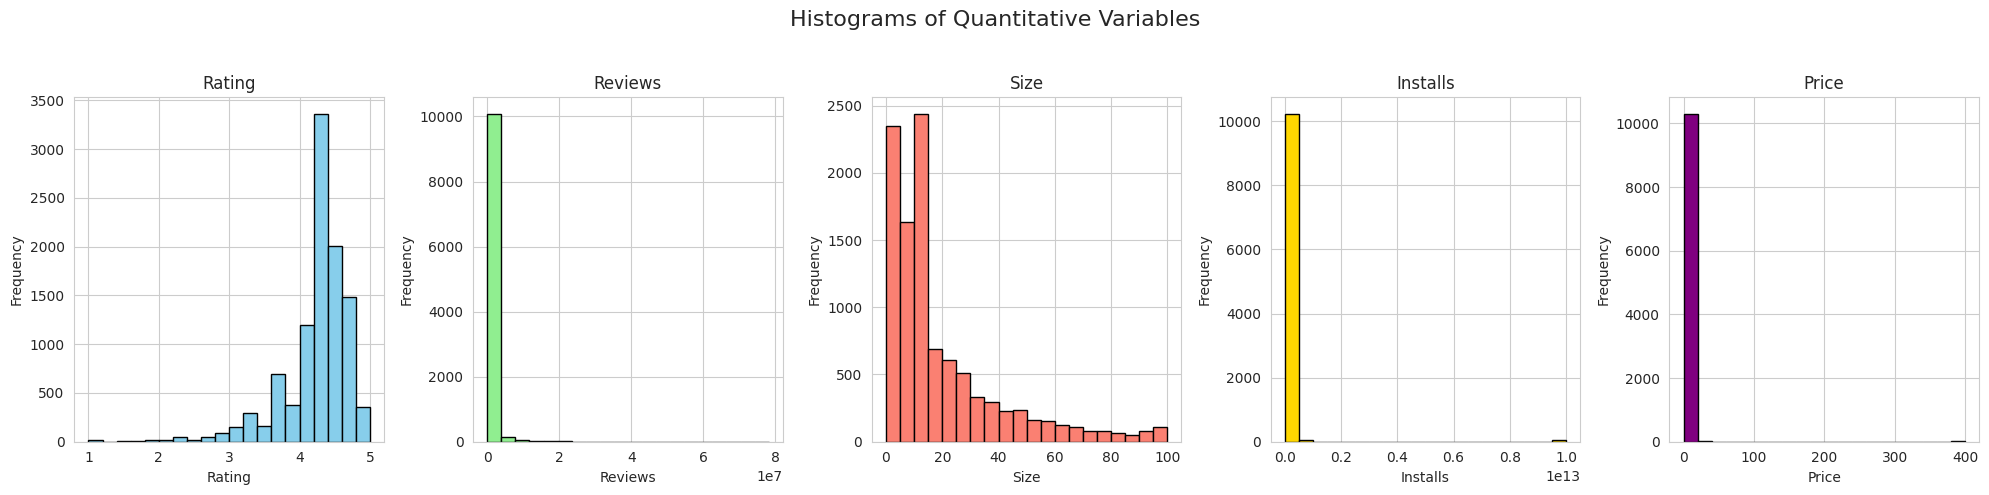

In [ ]:
# Selecting only the desired quantitative variables
quantitative_columns = ['Rating', 'Reviews', 'Size', 'Installs', 'Price']
df_quantitative = df[quantitative_columns]

# Colors for each histogram
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'purple']

# Plot histograms for each quantitative variable with different colors
fig, axes = plt.subplots(nrows=1, ncols=len(quantitative_columns), figsize=(20, 5))
fig.suptitle("Histograms of Quantitative Variables", fontsize=16)

for i, column in enumerate(quantitative_columns):
    axes[i].hist(df_quantitative[column], bins=20, color=colors[i], edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit titles
plt.show()

- Rating distribution is positively skewed pattern with a concentration around high ratings.
- Reviews distribution shows that most of the apps has low review counts
- Size distribution varies, with a concentration around smaller sizes.
- Price demonstrates that the majority of apps are free, and very few apps are high-priced.

**Correlation Analysis**

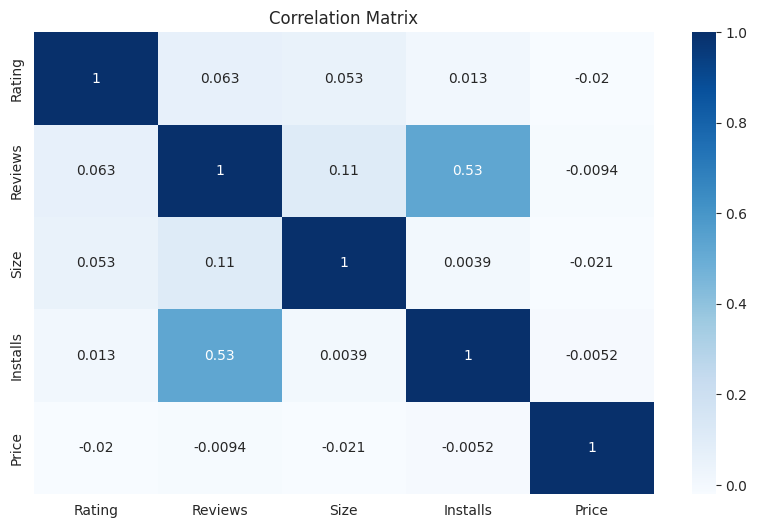

In [ ]:
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Create a correlation matrix for the numerical data
corr_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()



Significant correlations from the matrix include:

- Reviews and Installs have a correlation of 0.53. It is the strongest relationship overall, indicating that apps with more installs tend to have more reviews.


### 5. Exploring Reviews Dataset

In [ ]:
df_reviews = pd.read_csv('googleplaystore_user_reviews.csv')
df_reviews.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [ ]:
df_reviews.shape

(64295, 5)

**EDA**

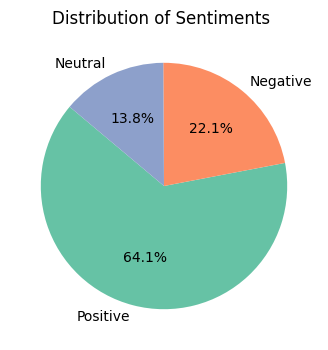

In [ ]:

sentiment_counts = df_reviews['Sentiment'].value_counts()

# Define a color palette for better visual appeal
colors = sns.color_palette("Set2")

# Plot the pie chart with improved colors
plt.figure(figsize=(4, 4))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors[:len(sentiment_counts)]
)

# Customize the chart
plt.title('Distribution of Sentiments ')
plt.show()




---



### 6. Feature Engineering and  preprocessing of merged dataset

**Sentiment Rating**

Normalize Sentiment_Polarity to a 1-5 scale

In [ ]:
df_reviews['Sentiment_Rating'] = ((df_reviews['Sentiment_Polarity'] - df_reviews['Sentiment_Polarity'].min()) /
                              (df_reviews['Sentiment_Polarity'].max() - df_reviews['Sentiment_Polarity'].min())) * 4 + 1

**Preprocessing and Cleaning for creating a merged dataset**

In [ ]:
common_apps = list(set(df_reviews['App'].unique()).intersection(set(df['App'].unique())))
df_reviews_filtered = df_reviews[df_reviews['App'].isin(common_apps)].copy()
df_filtered = df[df['App'].isin(common_apps)].copy()
merged_df = pd.merge( df_filtered, df_reviews_filtered, on='App')
merged_df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated,Updated_Month,Updated_Year,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Sentiment_Rating
0,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,50000000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,1,2018,A kid's excessive ads. The types ads allowed a...,Negative,-0.250,1.000000,2.50
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,50000000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,1,2018,It bad >:(,Negative,-0.725,0.833333,1.55
2,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,50000000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,1,2018,like,Neutral,0.000,0.000000,3.00
3,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,50000000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,1,2018,NaN,NaN,NaN,NaN,NaN
4,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,50000000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,1,2018,I love colors inspyering,Positive,0.500,0.600000,4.00


In [ ]:
merged_df = merged_df.dropna() \
                       .groupby('App', as_index=False) \
                       .first()  # Keep only the first unique record for each app


**Average Sentiment Rating**

In [ ]:

average_sentiment_ratings = merged_df.groupby('App')['Sentiment_Rating'].mean()

# Add the average Sentiment_Rating as a new column to merged_df
merged_df['Average_Sentiment_Rating'] = merged_df['App'].map(average_sentiment_ratings)

**Numeric and Sentiment Rating Discrepancy**

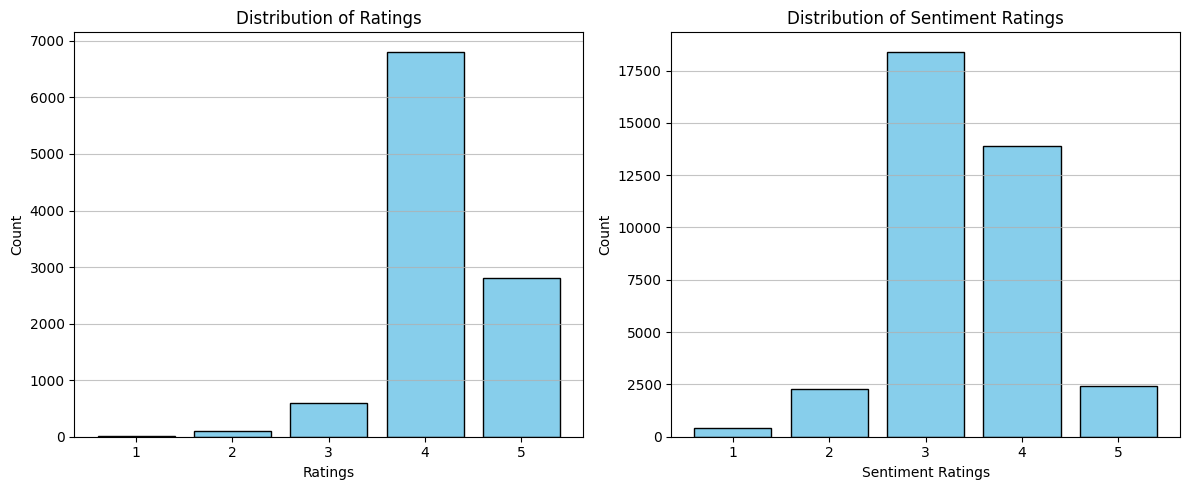

In [ ]:

# Define bins and labels
bins = [0, 1.4, 2.4, 3.4, 4.4, 5]
labels = [1, 2, 3, 4, 5]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Sentiment ratings
df_reviews['Sentiment_Ratings_Labels'] = pd.cut(df_reviews['Sentiment_Rating'],
                                                  bins=bins,
                                                  labels=labels,
                                                  include_lowest=True)

sentiment_rating_counts = df_reviews['Sentiment_Ratings_Labels'].value_counts().sort_index()

axs[1].bar(sentiment_rating_counts.index.astype(str), sentiment_rating_counts.values, color='skyblue', edgecolor='black')
axs[1].set_xlabel('Sentiment Ratings')
axs[1].set_ylabel('Count')
axs[1].set_title('Distribution of Sentiment Ratings')
axs[1].grid(axis='y', alpha=0.75)

# Rating
df['Rating_Labels'] = pd.cut(df['Rating'], bins=bins, labels=labels, include_lowest=True)

rating_counts = df['Rating_Labels'].value_counts().sort_index()

axs[0].bar(rating_counts.index.astype(str), rating_counts.values, color='skyblue', edgecolor='black')
axs[0].set_xlabel('Ratings')
axs[0].set_ylabel('Count')
axs[0].set_title('Distribution of Ratings')
axs[0].grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()


In [ ]:
merged_df['Discrepancy'] = abs(merged_df['Rating'] - merged_df['Average_Sentiment_Rating'])

In [ ]:
merged_df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated,Updated_Month,Updated_Year,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Sentiment_Rating,Average_Sentiment_Rating,Discrepancy
0,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,50000000,Free,0.0,Everyone 10+,Health & Fitness,2017-02-17,2,2017,I like eat delicious food. That's I'm cooking ...,Positive,1.000000,0.533333,5.000000,5.000000,1.000000
1,11st,SHOPPING,3.8,48732,20.0,10000000000,Free,0.0,Everyone,Shopping,2018-07-31,7,2018,Horrible ID verification,Negative,-1.000000,1.000000,1.000000,1.000000,2.800000
2,1800 Contacts - Lens Store,MEDICAL,4.7,23160,26.0,1000000000,Free,0.0,Everyone,Medical,2018-07-27,7,2018,Great hassle free way order contacts. Got call...,Positive,0.600000,0.775000,4.200000,4.200000,0.500000
3,1LINE – One Line with One Touch,GAME,4.6,214878,10.0,10000000000,Free,0.0,Everyone,Board,2018-08-03,8,2018,"gets 1* there's ad every single level restart,...",Negative,-0.157143,0.704762,2.685714,2.685714,1.914286
4,2018Emoji Keyboard 😂 Emoticons Lite -sticker&gif,PERSONALIZATION,4.2,115773,13.0,10000000000,Free,0.0,Everyone,Personalization,2018-05-22,5,2018,Like The Old Version Better Where Backspace Is...,Positive,0.300000,0.350000,3.600000,3.600000,0.600000


In [ ]:
merged_df_copy = merged_df.copy()
merged_df_copy.shape

(816, 20)

**Extracting more data from df dataset**

In [ ]:
new_df = df[~df['App'].isin(merged_df_copy['App'])]
new_df = pd.concat([merged_df_copy, new_df], ignore_index=True)
new_df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,...,Updated_Month,Updated_Year,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Sentiment_Rating,Average_Sentiment_Rating,Discrepancy,Rating_Labels
0,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,50000000,Free,0.0,Everyone 10+,Health & Fitness,...,2,2017,I like eat delicious food. That's I'm cooking ...,Positive,1.000000,0.533333,5.000000,5.000000,1.000000,NaN
1,11st,SHOPPING,3.8,48732,20.0,10000000000,Free,0.0,Everyone,Shopping,...,7,2018,Horrible ID verification,Negative,-1.000000,1.000000,1.000000,1.000000,2.800000,NaN
2,1800 Contacts - Lens Store,MEDICAL,4.7,23160,26.0,1000000000,Free,0.0,Everyone,Medical,...,7,2018,Great hassle free way order contacts. Got call...,Positive,0.600000,0.775000,4.200000,4.200000,0.500000,NaN
3,1LINE – One Line with One Touch,GAME,4.6,214878,10.0,10000000000,Free,0.0,Everyone,Board,...,8,2018,"gets 1* there's ad every single level restart,...",Negative,-0.157143,0.704762,2.685714,2.685714,1.914286,NaN
4,2018Emoji Keyboard 😂 Emoticons Lite -sticker&gif,PERSONALIZATION,4.2,115773,13.0,10000000000,Free,0.0,Everyone,Personalization,...,5,2018,Like The Old Version Better Where Backspace Is...,Positive,0.300000,0.350000,3.600000,3.600000,0.600000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10078,Sya9a Maroc - FR,FAMILY,4.5,38,53.0,500000,Free,0.0,Everyone,Education,...,7,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
10079,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6,1000,Free,0.0,Everyone,Education,...,7,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
10080,Parkinson Exercices FR,MEDICAL,4.3,3,9.5,100000,Free,0.0,Everyone,Medical,...,1,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
10081,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,13.0,100000,Free,0.0,Mature 17+,Books & Reference,...,1,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [ ]:
new_df = new_df.drop_duplicates(subset=['App'], keep='first')
new_df.shape

(9648, 21)

**Handling Missing Values**

In [ ]:
print(new_df.isnull().sum())

App                            0
Category                       0
Rating                         0
Reviews                        0
Size                           0
Installs                       0
Type                           0
Price                          0
Content_Rating                 0
Genres                         0
Last_Updated                   0
Updated_Month                  0
Updated_Year                   0
Translated_Review           8832
Sentiment                   8832
Sentiment_Polarity          8832
Sentiment_Subjectivity      8832
Sentiment_Rating            8832
Average_Sentiment_Rating    8832
Discrepancy                 8832
Rating_Labels                816
dtype: int64


In [ ]:
new_df['Average_Sentiment_Rating'] = new_df.groupby(['Category', 'Content_Rating'])['Average_Sentiment_Rating'].transform(lambda x: x.fillna(x.median()))
new_df['Average_Sentiment_Rating'].fillna(new_df['Average_Sentiment_Rating'].median(), inplace=True)
new_df['Discrepancy'] = new_df.apply(lambda row: abs(row['Rating'] - row['Average_Sentiment_Rating']) if pd.isnull(row['Discrepancy']) else row['Discrepancy'], axis=1)

#The other variables will be dropped later as they arent useful

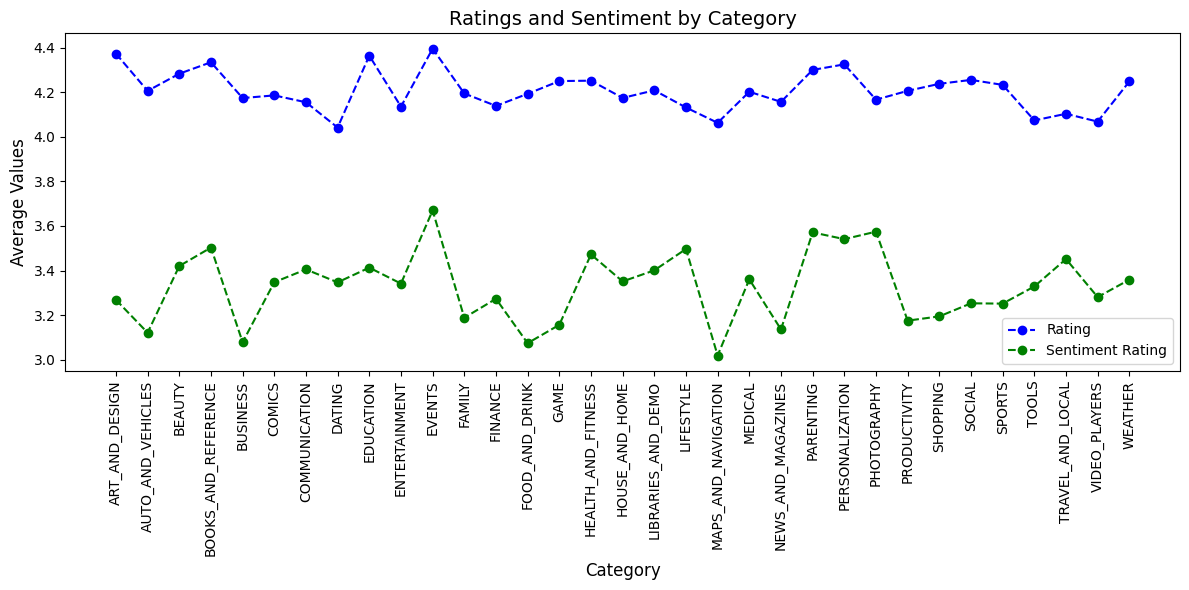

In [ ]:

category_ratings = new_df.groupby('Category')['Rating'].mean()
category_sentiment = new_df.groupby('Category')['Average_Sentiment_Rating'].mean()

# Plot the Ratings and Sentiment by Category
plt.figure(figsize=(12, 6))

# Plot Average Ratings
plt.plot(
    category_ratings.index,
    category_ratings.values,
    linestyle='--',
    color='b',
    marker='o',
    label='Rating'
)

# Plot Average Sentiment Ratings
plt.plot(
    category_sentiment.index,
    category_sentiment.values,
    linestyle='--',
    color='g',
    marker='o',
    label='Sentiment Rating'
)

# Add title and labels
plt.title('Ratings and Sentiment by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Values', fontsize=12)
plt.xticks(rotation=90)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


**User Engagement (Reviews and Installs Interaction)**

There’s high correlation between reviews and installs which represnets user engagement

In [ ]:
new_df['User_Engagement'] = np.log1p(new_df['Reviews'] * new_df['Installs'])

# applied a logarithmic transformation as the data is skewed and with large ranges

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


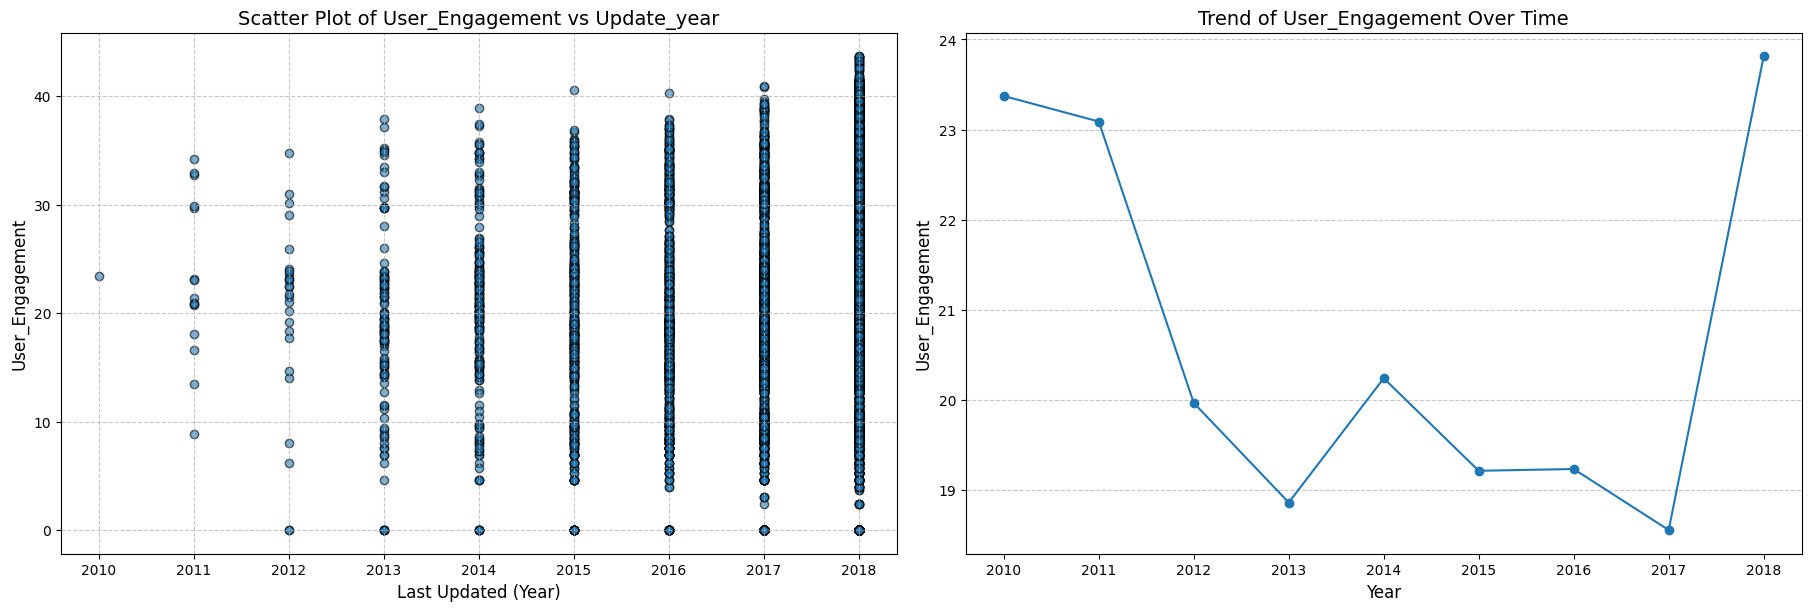

In [ ]:
# Preparing data for line plot
grouped_data = new_df.groupby('Updated_Year')['User_Engagement'].mean().reset_index()

# Creating a single figure for both plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)

# Scatter Plot
axes[0].scatter(new_df['Updated_Year'], new_df['User_Engagement'], alpha=0.6, edgecolor='k')
axes[0].set_title('Scatter Plot of User_Engagement vs Update_year', fontsize=14)
axes[0].set_xlabel('Last Updated (Year)', fontsize=12)
axes[0].set_ylabel('User_Engagement', fontsize=12)
axes[0].grid(axis='both', linestyle='--', alpha=0.7)

# Line Plot
axes[1].plot(grouped_data['Updated_Year'], grouped_data['User_Engagement'], marker='o')
axes[1].set_title('Trend of User_Engagement Over Time', fontsize=14)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('User_Engagement', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Show the combined plots
plt.show()


Apps updated more recently shows higher and more interactions, indicating that frequent updates drive user engagement.
The spike in 2018 interactions highlights the strong link between timely updates and app success.

**Evolution of discrepancies over time as per the app updates**

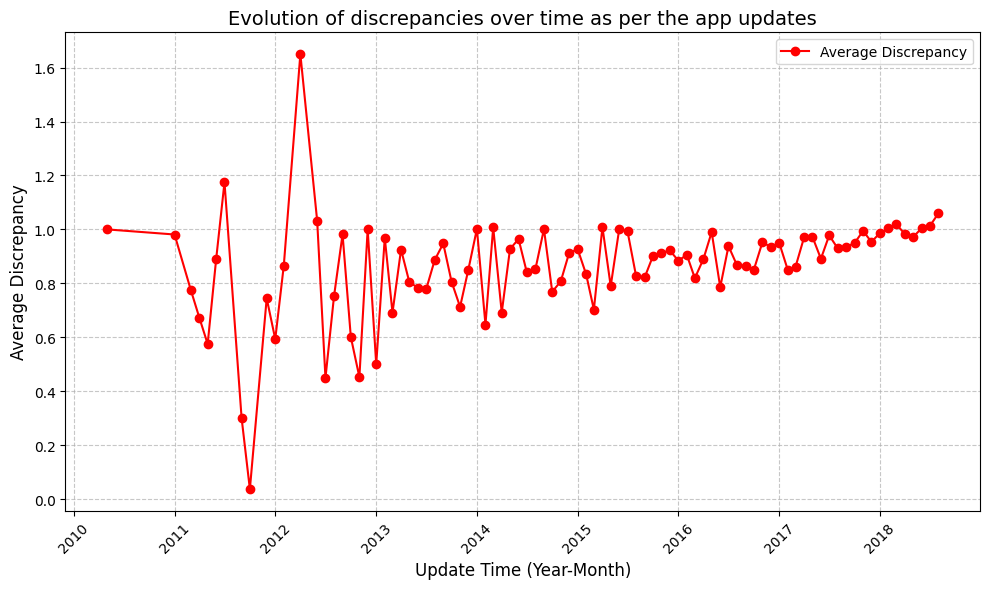

In [ ]:
new_df['Updated_YearMonth'] = pd.to_datetime(new_df['Updated_Year'].astype(str) + '-' + new_df['Updated_Month'].astype(str) + '-01')
average_discrepancy = new_df.groupby('Updated_YearMonth')['Discrepancy'].mean().reset_index()

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(average_discrepancy['Updated_YearMonth'], average_discrepancy['Discrepancy'], marker='o', linestyle='-', color='red', label='Average Discrepancy')

# Formatting the chart
plt.title('Evolution of discrepancies over time as per the app updates', fontsize=14)
plt.xlabel('Update Time (Year-Month)', fontsize=12)
plt.ylabel('Average Discrepancy', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


This Graph indicates that early app updates were less effective or irregular, causing higher discrepancies. Over time, as updates became more frequent and targeted, discrepancies reduced.


In [ ]:
# new_df = new_df.drop(columns='Updated_YearMonth', errors='ignore')

**Success Criteria**

In [ ]:
new_df.describe()

,Rating,Reviews,Size,Installs,Price,Last_Updated,Updated_Month,Updated_Year,Sentiment_Polarity,Sentiment_Subjectivity,Sentiment_Rating,Average_Sentiment_Rating,Discrepancy,User_Engagement,Updated_YearMonth
count,9648.000000,9.648000e+03,9648.000000,9.648000e+03,9648.000000,9648,9648.000000,9648.000000,816.000000,816.000000,816.000000,9648.000000,9648.000000,9638.000000,9648
mean,4.192465,2.168369e+05,19.462359,2.640558e+10,1.100193,2017-10-31 01:00:08.955223808,6.365464,2017.346186,0.167156,0.493432,3.334311,3.287113,0.975974,22.111355,2017-10-16 09:47:36.716417792
min,1.000000,0.000000e+00,0.010000,0.000000e+00,0.000000,2010-05-21 00:00:00,1.000000,2010.000000,-1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2010-05-01 00:00:00
25%,4.000000,2.500000e+01,5.300000,1.000000e+05,0.000000,2017-08-07 18:00:00,5.000000,2017.000000,0.000000,0.397586,3.000000,3.168519,0.722302,14.978662,2017-08-01 00:00:00
50%,4.300000,9.690000e+02,13.000000,1.000000e+07,0.000000,2018-05-05 00:00:00,7.000000,2018.000000,0.149360,0.511964,3.298720,3.268485,1.000665,22.729798,2018-05-01 00:00:00
75%,4.500000,2.944925e+04,25.000000,1.000000e+09,0.000000,2018-07-17 00:00:00,8.000000,2018.000000,0.333333,0.615017,3.666667,3.399335,1.236905,31.144244,2018-07-01 00:00:00
max,5.000000,7.815831e+07,100.000000,1.000000e+13,400.000000,2018-08-08 00:00:00,12.000000,2018.000000,1.000000,1.000000,5.000000,5.000000,3.400000,43.660258,2018-08-01 00:00:00
std,0.496552,1.832349e+06,20.554223,4.555235e+11,16.861727,NaN,2.659280,1.137109,0.302656,0.217704,0.605313,0.249623,0.411216,10.660291,NaN


from here we can observe that data is not normally distributed, some features have means significantly higher than their medians

In [ ]:


# Calculate median values for defining thresholds
median_interaction = new_df['User_Engagement'].median()
median_discrepancy = new_df['Discrepancy'].median()
current_date = new_df['Last_Updated'].max()  # Latest date in the dataset

def categorize_success(row, interaction_tolerance=0.1, discrepancy_tolerance=0.1, recent_days_threshold=730, moderately_recent_days_threshold=1460):
    """
    Categorize app success based on User_Engagement, Discrepancy, and Last_Updated.

    Parameters:
    - interaction_tolerance: Flexibility for interaction values (default 10%).
    - discrepancy_tolerance: Flexibility for discrepancy values (default 10%).
    - recent_days_threshold: Days to consider an update "recent" (default 2 years).
    - moderately_recent_days_threshold: Days to consider an update "moderately recent" (default 4 years).
    """

    # Define tolerance ranges
    interaction_lower = median_interaction * (1 - interaction_tolerance)
    interaction_upper = median_interaction * (1 + interaction_tolerance)
    discrepancy_upper = median_discrepancy * (1 + discrepancy_tolerance)

    # Calculate days since last update
    days_since_update = (current_date - row['Last_Updated']).days

    # Define recency conditions
    is_recent = days_since_update <= recent_days_threshold
    is_moderately_recent = days_since_update <= moderately_recent_days_threshold

    # Categorize Success
    if (interaction_lower <= row['User_Engagement'] <= interaction_upper and
        row['Discrepancy'] <= discrepancy_upper and is_recent):
        return 'Successful'

    elif (median_interaction / 2 * (1 - interaction_tolerance) <= row['User_Engagement'] <= median_interaction / 2 * (1 + interaction_tolerance) and
          row['Discrepancy'] <= median_discrepancy * 1.5 * (1 + discrepancy_tolerance) and
          is_moderately_recent):
        return 'Moderately Successful'

    # Default to Unsuccessful
    return 'Unsuccessful'

# Apply categorization
new_df['Success Category'] = new_df.apply(
    categorize_success,
    axis=1,
    interaction_tolerance=0.15,  # Example: 15% tolerance
    discrepancy_tolerance=0.2,  # Example: 20% tolerance
    recent_days_threshold=365 * 1.5,  # Example: 1.5 years
    moderately_recent_days_threshold=365 * 3  # Example: 3 years
)

# Verify the distribution of each category
print(new_df['Success Category'].value_counts())


Success Category
Unsuccessful             8099
Successful               1212
Moderately Successful     337
Name: count, dtype: int64


- Used median since its good technique when the data is skewd as it is robust to outliers
- Used tolerance approach to ensure flexibility in defining success categories without being too rigid about the exact values.

In [ ]:
new_df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,...,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Sentiment_Rating,Average_Sentiment_Rating,Discrepancy,Rating_Labels,User_Engagement,Updated_YearMonth,Success Category
0,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,50000000,Free,0.0,Everyone 10+,Health & Fitness,...,Positive,1.000000,0.533333,5.000000,5.000000,1.000000,NaN,25.547572,2017-02-01,Successful
1,11st,SHOPPING,3.8,48732,20.0,10000000000,Free,0.0,Everyone,Shopping,...,Negative,-1.000000,1.000000,1.000000,1.000000,2.800000,NaN,33.819942,2018-07-01,Unsuccessful
2,1800 Contacts - Lens Store,MEDICAL,4.7,23160,26.0,1000000000,Free,0.0,Everyone,Medical,...,Positive,0.600000,0.775000,4.200000,4.200000,0.500000,NaN,30.773448,2018-07-01,Unsuccessful
3,1LINE – One Line with One Touch,GAME,4.6,214878,10.0,10000000000,Free,0.0,Everyone,Board,...,Negative,-0.157143,0.704762,2.685714,2.685714,1.914286,NaN,35.303677,2018-08-01,Unsuccessful
4,2018Emoji Keyboard 😂 Emoticons Lite -sticker&gif,PERSONALIZATION,4.2,115773,13.0,10000000000,Free,0.0,Everyone,Personalization,...,Positive,0.300000,0.350000,3.600000,3.600000,0.600000,NaN,34.685238,2018-05-01,Unsuccessful
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10078,Sya9a Maroc - FR,FAMILY,4.5,38,53.0,500000,Free,0.0,Everyone,Education,...,NaN,NaN,NaN,NaN,3.200000,1.300000,5,16.759950,2017-07-01,Unsuccessful
10079,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6,1000,Free,0.0,Everyone,Education,...,NaN,NaN,NaN,NaN,3.200000,1.800000,5,8.294300,2018-07-01,Unsuccessful
10080,Parkinson Exercices FR,MEDICAL,4.3,3,9.5,100000,Free,0.0,Everyone,Medical,...,NaN,NaN,NaN,NaN,3.333333,0.966667,4,12.611541,2017-01-01,Moderately Successful
10081,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,13.0,100000,Free,0.0,Mature 17+,Books & Reference,...,NaN,NaN,NaN,NaN,3.268485,1.231515,5,16.249124,2015-01-01,Unsuccessful


**Dropping not useful columns**

In [ ]:
# saving the app For Recommendation System
new_df_copy = new_df.copy()

In [ ]:
new_df.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content_Rating', 'Genres', 'Last_Updated', 'Updated_Month',
       'Updated_Year', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity',
       'Sentiment_Subjectivity', 'Sentiment_Rating',
       'Average_Sentiment_Rating', 'Discrepancy', 'Rating_Labels',
       'User_Engagement', 'Updated_YearMonth', 'Success Category'],
      dtype='object')

In [ ]:
columns_to_drop = ['Genres', 'Updated_Month', 'Translated_Review', 'Sentiment' ,'Sentiment_Polarity', 'Sentiment_Subjectivity', 'Sentiment_Rating', 'Rating_Bins', 'Rating_Labels', 'Sentiment_Ratings_Labels', 'Updated_YearMonth']
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')


**Handling Missing Values**

In [ ]:
print(new_df.isnull().sum())

App                          0
Category                     0
Rating                       0
Reviews                      0
Size                         0
Installs                     0
Type                         0
Price                        0
Content_Rating               0
Last_Updated                 0
Updated_Year                 0
Average_Sentiment_Rating     0
Discrepancy                  0
User_Engagement             10
Success Category             0
dtype: int64


In [ ]:
new_df = new_df.dropna()

**Encoding categorical Variables**

In [ ]:
# Categorical features
cat_features=[col for col in new_df.columns if new_df[col].dtype=='O']
cat_features

['App', 'Category', 'Type', 'Content_Rating', 'Success Category']

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for feature in cat_features:
  if feature != 'App':  # Exclude 'App' feature from encoding
    new_df[feature] = le.fit_transform(new_df[feature])
print(new_df.head())

                                                App  Category  Rating  \
0                             10 Best Foods for You        15     4.0   
1                                              11st        26     3.8   
2                        1800 Contacts - Lens Store        20     4.7   
3                   1LINE – One Line with One Touch        14     4.6   
4  2018Emoji Keyboard 😂 Emoticons Lite -sticker&gif        23     4.2   

   Reviews  Size     Installs  Type  Price  Content_Rating Last_Updated  \
0     2490   3.8     50000000     0    0.0               2   2017-02-17   
1    48732  20.0  10000000000     0    0.0               1   2018-07-31   
2    23160  26.0   1000000000     0    0.0               1   2018-07-27   
3   214878  10.0  10000000000     0    0.0               1   2018-08-03   
4   115773  13.0  10000000000     0    0.0               1   2018-05-22   

   Updated_Year  Average_Sentiment_Rating  Discrepancy  User_Engagement  \
0          2017                  5.

**Feature Importance**

                     Feature  Importance
11           User_Engagement    0.312670
2                    Reviews    0.186586
4                   Installs    0.164993
10               Discrepancy    0.125361
12    Days_Since_Last_Update    0.085789
8               Updated_Year    0.047036
1                     Rating    0.038631
9   Average_Sentiment_Rating    0.013689
3                       Size    0.012614
0                   Category    0.006734
6                      Price    0.002827
7             Content_Rating    0.001536
5                       Type    0.001535


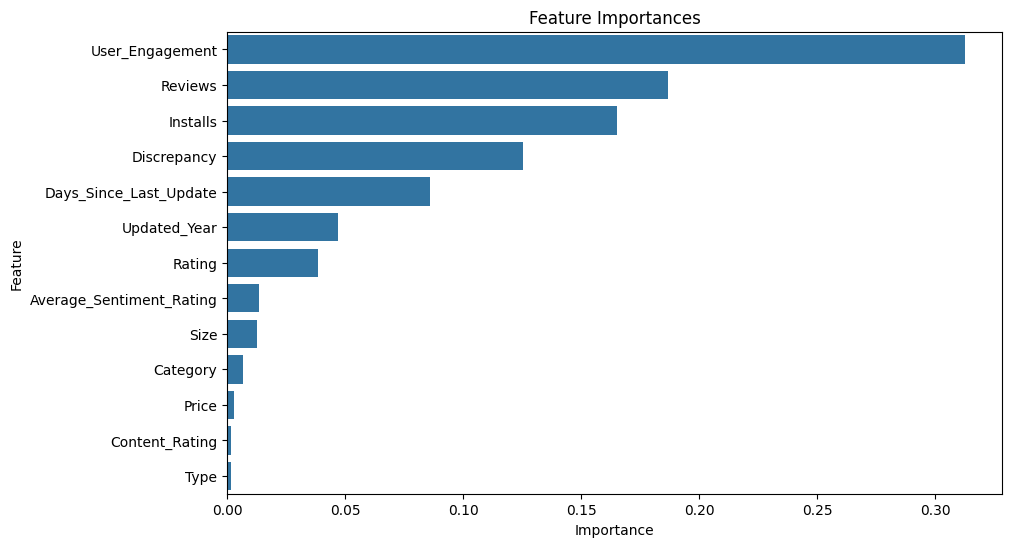

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Last_Updated' to numerical features (e.g., days since the latest update)
current_date = new_df['Last_Updated'].max()
new_df['Days_Since_Last_Update'] = (current_date - new_df['Last_Updated']).dt.days

# Drop the original 'Last_Updated' column after feature extraction
X = new_df.drop(columns=['Success Category', 'App', 'Last_Updated'], axis=1)
y = new_df['Success Category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Print feature importances
print(feature_importance_df)

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()


### 7. Prediction of Success Level

**Distribution of Success Category**

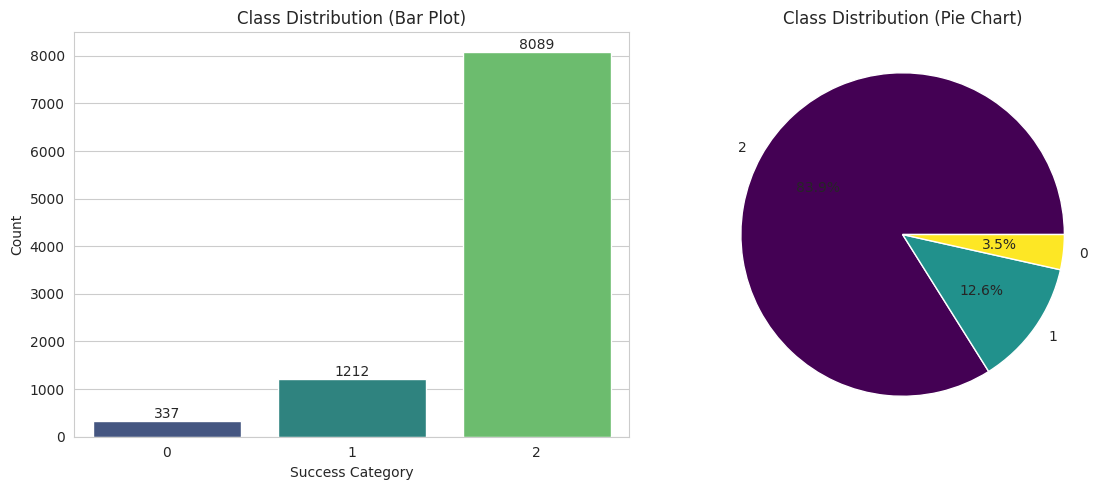

In [ ]:
# Get the counts for each Success Category
success_counts = new_df['Success Category'].value_counts()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Bar Plot in the first subplot
barplot = sns.countplot(ax=axes[0], x='Success Category', data=new_df, palette='viridis')
axes[0].set_title('Class Distribution (Bar Plot)')
axes[0].set_xlabel('Success Category')
axes[0].set_ylabel('Count')

# Add counts on top of the bars
for p in barplot.patches:
    barplot.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom', fontsize=10
    )

# Pie Chart in the second subplot
new_df['Success Category'].value_counts().plot.pie(
    autopct='%1.1f%%',
    ax=axes[1],
    cmap='viridis'
)
axes[1].set_title('Class Distribution (Pie Chart)')
axes[1].set_ylabel('')  # Optional to remove the y-label

# Adjust layout
plt.tight_layout()
plt.show()


**Data Spliting**

In [ ]:
# Define features and target
X = new_df.drop(columns=['App', 'Success Category', 'Discrepancy', 'User_Engagement', 'Last_Updated'])
y = new_df['Success Category']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.grid(False)  # Turn off grid lines
    plt.show()


The dataset is highly imbalanced, hence using Sampling technique

**SMOTEENN ( hybrid approach that combines oversampling and undersampling)**

Logistic Regression - With Hybrid Sampling (SMOTEENN)


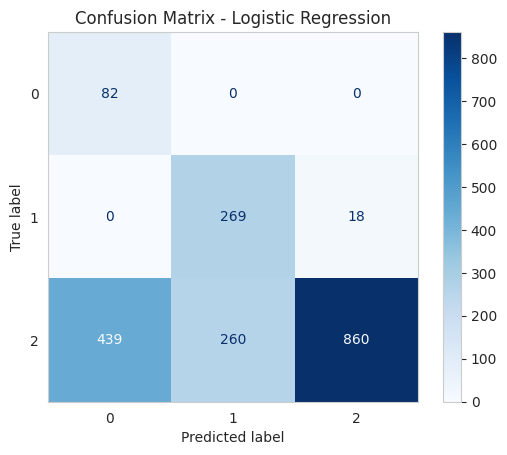

Model performance for Training set
- Accuracy: 0.8480
- F1 score: 0.8385
- Precision: 0.8542
- Recall: 0.8480
Model performance for Test set
- Accuracy: 0.6281
- F1 score: 0.6804
- Precision: 0.8744
- Recall: 0.6281


Decision Tree - With Hybrid Sampling (SMOTEENN)


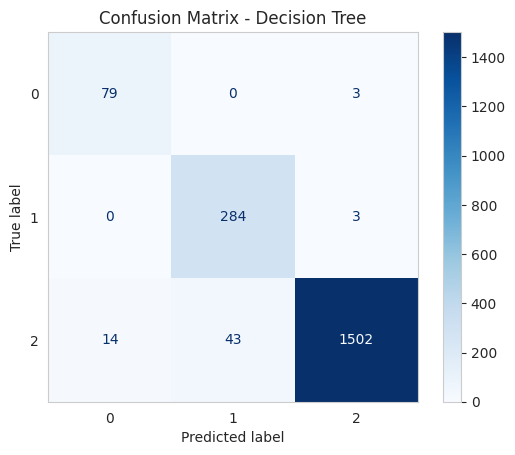

Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
Model performance for Test set
- Accuracy: 0.9673
- F1 score: 0.9681
- Precision: 0.9708
- Recall: 0.9673


Random Forest - With Hybrid Sampling (SMOTEENN)


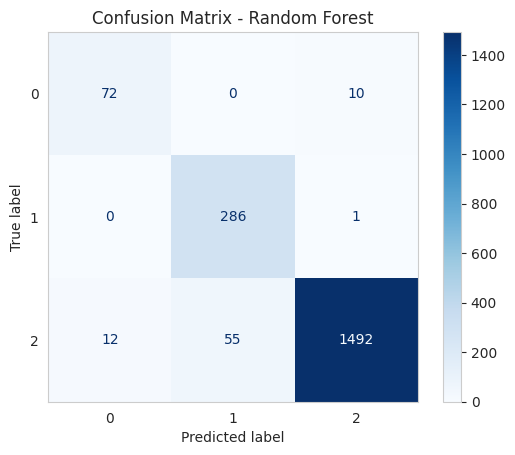

Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
Model performance for Test set
- Accuracy: 0.9595
- F1 score: 0.9605
- Precision: 0.9640
- Recall: 0.9595




In [ ]:
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
)


# Define hybrid sampling strategy (SMOTE + ENN)
hybrid_sampler = SMOTEENN(random_state=42)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

# Function to apply hybrid sampling and evaluate performance
def evaluate_with_hybrid_sampling(X_train, y_train, X_test, y_test, model, sampler):
    # Apply hybrid sampling
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

    # Train the model on resampled data
    model.fit(X_train_resampled, y_train_resampled)

    # Predictions
    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_test_pred, model_name)


    # Training set performance
    model_train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    model_train_f1 = f1_score(y_train_resampled, y_train_pred, average='weighted')
    model_train_precision = precision_score(y_train_resampled, y_train_pred, average='weighted')
    model_train_recall = recall_score(y_train_resampled, y_train_pred, average='weighted')

    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    model_test_precision = precision_score(y_test, y_test_pred, average='weighted')
    model_test_recall = recall_score(y_test, y_test_pred, average='weighted')

    return {
        "Train Accuracy": model_train_accuracy,
        "Train F1 Score": model_train_f1,
        "Train Precision": model_train_precision,
        "Train Recall": model_train_recall,
        "Test Accuracy": model_test_accuracy,
        "Test F1 Score": model_test_f1,
        "Test Precision": model_test_precision,
        "Test Recall": model_test_recall
    }

# Evaluate each model with hybrid sampling
for model_name, model in models.items():
    print(f"{model_name} - With Hybrid Sampling (SMOTEENN)")

    # Evaluate with hybrid sampling
    hybrid_results = evaluate_with_hybrid_sampling(X_train, y_train, X_test, y_test, model, sampler=hybrid_sampler)

    print("Model performance for Training set")
    print("- Accuracy: {:.4f}".format(hybrid_results["Train Accuracy"]))
    print("- F1 score: {:.4f}".format(hybrid_results["Train F1 Score"]))
    print("- Precision: {:.4f}".format(hybrid_results["Train Precision"]))
    print("- Recall: {:.4f}".format(hybrid_results["Train Recall"]))

    print("=" * 35)
    print("Model performance for Test set")
    print("- Accuracy: {:.4f}".format(hybrid_results["Test Accuracy"]))
    print("- F1 score: {:.4f}".format(hybrid_results["Test F1 Score"]))
    print("- Precision: {:.4f}".format(hybrid_results["Test Precision"]))
    print("- Recall: {:.4f}".format(hybrid_results["Test Recall"]))
    print("=" * 35)
    print("\n")


**Feedforward Neural Network (With Hyper-parameter Tuning)**

In [ ]:
# Un comment when you require installation of the following
# !pip install tensorflow
# !pip install keras-tuner

Trial 10 Complete [00h 00m 20s]
val_accuracy: 0.8527885675430298

Best val_accuracy So Far: 0.853437066078186
Total elapsed time: 00h 04m 14s

The optimal number of layers is 1.
The optimal units per layer are:
    - Layer 1: 64
    
    .
The optimal dropout rates are:
    - Layer 1: 0.2 (if dropout enabled: False).
    
    .
The optimal activation functions are:
    - Layer 1: relu
    
    .
The optimal optimizer is adam with a learning rate of 0.01.

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8160 - loss: 0.5432 - val_accuracy: 0.8482 - val_loss: 0.4421
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8416 - loss: 0.4490 - val_accuracy: 0.8521 - val_loss: 0.4268
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8498 - loss: 0.4255 - val_accuracy: 0.8515 - val_loss: 0.4212
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8459 - loss: 0.4185 - val_accuracy: 0.8495 - val_loss: 0.4098
Epoch 5/20
193/193 ━━━━━━━━━

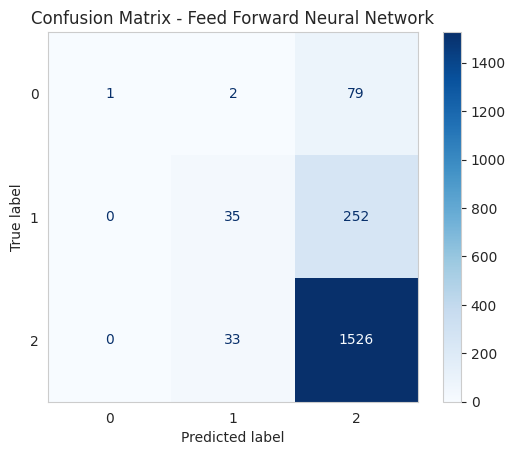

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt  # Install using `pip install keras-tuner`
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a function to build the model for tuning
def build_model(hp):
    model = keras.Sequential()
    # Tune the number of layers (up to 3 layers)
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i+1}', min_value=32, max_value=128, step=32),
            activation=hp.Choice(f'activation_{i+1}', ['relu', 'tanh'])
        ))
        # Tune dropout rate
        if hp.Boolean(f'dropout_{i+1}'):
            model.add(layers.Dropout(hp.Float(f'dropout_rate_{i+1}', 0.1, 0.5, step=0.1)))

    # Output layer
    model.add(layers.Dense(len(np.unique(y)), activation='softmax'))

    # Tune optimizer type and learning rate
    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    if optimizer == 'adam':
        optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
    elif optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
    else:
        optimizer = keras.optimizers.RMSprop(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Use Keras Tuner for hyperparameter optimization
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Increased number of hyperparameter combinations to try
    executions_per_trial=2,  # Average results over multiple runs
    directory='my_dir',
    project_name='enhanced_tuning'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the optimal hyperparameters
print(f"""
The optimal number of layers is {best_hps.get('num_layers')}.
The optimal units per layer are:
    - Layer 1: {best_hps.get('units_1')}
    {"- Layer 2: " + str(best_hps.get('units_2')) if best_hps.get('num_layers') > 1 else ""}
    {"- Layer 3: " + str(best_hps.get('units_3')) if best_hps.get('num_layers') > 2 else ""}.
The optimal dropout rates are:
    - Layer 1: {best_hps.get('dropout_rate_1')} (if dropout enabled: {best_hps.get('dropout_1')}).
    {"- Layer 2: " + str(best_hps.get('dropout_rate_2')) + " (if dropout enabled: " + str(best_hps.get('dropout_2')) + ")" if best_hps.get('num_layers') > 1 else ""}
    {"- Layer 3: " + str(best_hps.get('dropout_rate_3')) + " (if dropout enabled: " + str(best_hps.get('dropout_3')) + ")" if best_hps.get('num_layers') > 2 else ""}.
The optimal activation functions are:
    - Layer 1: {best_hps.get('activation_1')}
    {"- Layer 2: " + str(best_hps.get('activation_2')) if best_hps.get('num_layers') > 1 else ""}
    {"- Layer 3: " + str(best_hps.get('activation_3')) if best_hps.get('num_layers') > 2 else ""}.
The optimal optimizer is {best_hps.get('optimizer')} with a learning rate of {best_hps.get('learning_rate')}.
""")


# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=32)

# Evaluate the best model on the test set
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Test accuracy of the best model: {accuracy}')

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')  # Weighted for multi-class classification
print(f'F1 Score: {f1}')

# Optional: Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))

plot_confusion_matrix(y_test, y_pred_classes, "Feed Forward Neural Network")


### 8. Content-Based Recommendation System


**Recommendation system based on catrgory selction and discrepancy threashold:** The system prompts the user to input a category name and the desired number of apps and accepttable discrepancy. Based on this input, it recommends the top apps within the specified crieteria.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Normalize numerical features
numerical_features = ['Rating', 'Sentiment_Polarity', 'Discrepancy', 'User_Engagement']
scaler = MinMaxScaler()

# Handle missing values and scale numerical features
new_df_copy[numerical_features] = new_df_copy[numerical_features].fillna(0)
new_df_copy[numerical_features] = scaler.fit_transform(new_df_copy[numerical_features])

# Handle missing categorical values--- This is not needed , but just in case
new_df_copy['Category'] = new_df_copy['Category'].fillna('Unknown')
new_df_copy['Success Category'] = new_df_copy['Success Category'].fillna('Unknown')

# Apply Feature Weighting
new_df_copy['Weighted_Rating'] = new_df_copy['Rating'] * 0.5
new_df_copy['Weighted_Sentiment_Polarity'] = new_df_copy['Sentiment_Polarity'] * 0.3
new_df_copy['Weighted_Reviews_Installs'] = new_df_copy['User_Engagement'] * 0.1
new_df_copy['Weighted_Discrepancy'] = new_df_copy['Discrepancy'] * -0.2

# Combine numerical and categorical features
features = ['Category', 'Success Category', 'Weighted_Rating', 'Weighted_Sentiment_Polarity',
            'Weighted_Reviews_Installs', 'Weighted_Discrepancy']
feature_matrix = pd.get_dummies(new_df_copy[features])

# Compute Similarity
similarity_matrix = cosine_similarity(feature_matrix)

# Map DataFrame indices to the feature matrix indices
df_to_feature_matrix_indices = {index: idx for idx, index in enumerate(new_df_copy.index)}

# Recommendation Function with Hybrid Approach
def content_based_recommendations_by_category(category, n_recommendations=5, discrepancy_threshold=0.2):
    # Step 1: Filter apps in the specified category
    category_apps = new_df_copy[(new_df_copy['Category'] == category) &
                                (new_df_copy['Discrepancy'] <= discrepancy_threshold)]
    if category_apps.empty:
        return f"No apps found in the category '{category}' with discrepancy <= {discrepancy_threshold}."

    # Step 2: Map the indices of category apps to the feature matrix
    category_indices = [df_to_feature_matrix_indices[idx] for idx in category_apps.index]

    # Step 3: Compute mean similarity scores for apps in the category
    scores = similarity_matrix[category_indices].mean(axis=0)

    # Step 4: Sort apps by similarity score
    top_indices = scores.argsort()[::-1][:n_recommendations]  # Indices of top scores
    top_apps = new_df_copy.iloc[top_indices][['App', 'Category', 'Discrepancy']]  # Relevant columns

    # Update the index to start from 1
    top_apps.index = range(1, len(top_apps) + 1)

    return top_apps

# Example Usage
category = input("Enter a category: ")
n_top_apps = int(input("Enter the number of top apps to recommend: "))
discrepancy_threshold = float(input("Enter the maximum discrepancy threshold (e.g., 0.2): "))

recommendations = content_based_recommendations_by_category(category, n_top_apps, discrepancy_threshold)

if isinstance(recommendations, str):
    print(recommendations)
else:
    print("Top apps recommended:")
    print(recommendations)

print('\n...............................................................')
print('\n We are sure you will LOVE these recommendations :D')


Enter a category: GAME
Enter the number of top apps to recommend: 3
Enter the maximum discrepancy threshold (e.g., 0.2): 0.2
Top apps recommended:
                                             App Category  Discrepancy
1              L.A. Crime Stories Mad City Crime     GAME     0.119094
2                       Gang Wars of San Andreas     GAME     0.148506
3  Rage Z: Multiplayer Zombie FPS Online Shooter     GAME     0.148506

...............................................................

 We are sure you will LOVE these recommendations :D


**Below are other types of recommendations system that also can be useful for users** - The below recommendation systems are part of our experiments.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

This recommendation system suggests similar apps to a given app based on the combined features of user ratings and number of installs.

If a user enjoys the app "10 Best Foods for You", the below system can suggest other apps with comparable ratings and installs, even if they belong to a different category.

In [ ]:
new_df['preference_features'] = (new_df['Rating'].astype(str) + " " + new_df['Installs'].astype(str))

tfidf_preference = TfidfVectorizer(stop_words='english')
tfidf_matrix_preference = tfidf_preference.fit_transform(new_df['preference_features'])

cosine_sim_preference = cosine_similarity(tfidf_matrix_preference, tfidf_matrix_preference)

def get_preference_recommendations(app_name, cosine_sim=cosine_sim_preference):
    idx = new_df[new_df['App'] == app_name].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    app_indices = [i[0] for i in sim_scores]
    return new_df[['App', 'Rating', 'Installs', 'Category']].iloc[app_indices]

#EXAMPLE USAGE
preference_recommendations = get_preference_recommendations("10 Best Foods for You")
print(preference_recommendations)

                                                   App  Rating  Installs  \
6                  2Date Dating App, Love and matching     4.4  50000000   
13                                          4 in a Row     3.8  50000000   
14              4K Wallpapers and Ultra HD Backgrounds     4.6  50000000   
15                       7 Cups: Anxiety & Stress Chat     4.2  50000000   
18                      7 Weeks - Habit & Goal Tracker     4.4  50000000   
24                                        A Word A Day     3.7  50000000   
41                                       ARY NEWS URDU     4.4  50000000   
93   Amazon FreeTime – Kids’ Videos, Books, & TV shows     4.2  50000000   
115                                    Anthem Anywhere     2.7  50000000   
142                                      Azpen eReader     3.5  50000000   

     Category  
6           7  
13         14  
14         23  
15         15  
18         25  
24         11  
41         21  
93         22  
115        20  
142

The below recommendation system is another system that suggests similar apps based on their success category and app category.

If the input app is 10 Best Foods for You, which is in the High Success category and Health & Fitness, the system might recommend:

Apps in the High Success category and Health & Fitness. Apps in the High Success category but in related categories (e.g., "Lifestyle", "Cooking"). Apps with high ratings and similar appeal.

In [ ]:
new_df['success_features'] = (new_df['Success Category'].astype(str) + " " + new_df['Category'].astype(str))

tfidf_success = TfidfVectorizer(stop_words='english')
tfidf_matrix_success = tfidf_success.fit_transform(new_df['success_features'])

cosine_sim_success = cosine_similarity(tfidf_matrix_success, tfidf_matrix_success)

def get_success_recommendations(app_name, cosine_sim=cosine_sim_success):
    idx = new_df[new_df['App'] == app_name].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    app_indices = [i[0] for i in sim_scores]
    return new_df[['App', 'Success Category', 'Category', 'Rating']].iloc[app_indices]

success_recommendations = get_success_recommendations("10 Best Foods for You")
print(success_recommendations)

                                                   App  Success Category  \
5                         21-Day Meditation Experience                 2   
10          30 Day Fitness Challenge - Workout at Home                 2   
15                       7 Cups: Anxiety & Stress Chat                 2   
17                                    7 Minute Workout                 2   
21                        8fit Workouts & Meal Planner                 2   
52                         Abs Training-Burn belly fat                 2   
204  Best Ovulation Tracker Fertility Calendar App ...                 2   
208                     BetterMe: Weight Loss Workouts                 2   
216                Bike Computer - GPS Cycling Tracker                 2   
218                             Binaural Beats Therapy                 2   

     Category  Rating  
5          15     4.4  
10         15     4.8  
15         15     4.2  
17         15     4.5  
21         15     4.6  
52         15     4

This recommendation system targets apps that are similar in size and pricing, catering to users with storage or budget constraints.

In [ ]:
new_df['size_price_features'] = (new_df['Size'].astype(str) + " " + new_df['Price'].astype(str))
tfidf_size_price = TfidfVectorizer(stop_words='english')
tfidf_matrix_size_price = tfidf_size_price.fit_transform(new_df['size_price_features'])
cosine_sim_size_price = cosine_similarity(tfidf_matrix_size_price, tfidf_matrix_size_price)

def get_size_price_recommendations(app_name, cosine_sim=cosine_sim_size_price):
    idx = new_df[new_df['App'] == app_name].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    app_indices = [i[0] for i in sim_scores]
    return new_df[['App', 'Size', 'Price', 'Category', 'Rating']].iloc[app_indices]

size_price_recommendations = get_size_price_recommendations("10 Best Foods for You")
print(size_price_recommendations)

                                                 App  Size  Price  Category  \
1                                               11st  20.0    0.0        26   
2                         1800 Contacts - Lens Store  26.0    0.0        20   
3                    1LINE – One Line with One Touch  10.0    0.0        14   
4   2018Emoji Keyboard 😂 Emoticons Lite -sticker&gif  13.0    0.0        23   
5                       21-Day Meditation Experience  15.0    0.0        15   
6                2Date Dating App, Love and matching   8.1    0.0         7   
7                        2GIS: directory & navigator  13.0    0.0        30   
8                                          2RedBeans  32.0    0.0         7   
9                      2ndLine - Second Phone Number  32.0    0.0         6   
10        30 Day Fitness Challenge - Workout at Home  13.0    0.0        15   

    Rating  
1      3.8  
2      4.7  
3      4.6  
4      4.2  
5      4.4  
6      4.4  
7      4.5  
8      4.0  
9      4.2  


***......................................................................................The End....................:.....................................................***